In [1]:
%pylab inline
import os
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import corner
import emcee

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from gala.dynamics import mockstream as ms
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import scipy.interpolate

from scipy.stats import binned_statistic
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy import optimize, stats
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

from matplotlib.patches import Rectangle
from gala.coordinates import GD1Koposov10
import gala.coordinates as gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.coordinates import SkyCoord, ICRS, Galactocentric, galactocentric_frame_defaults
GCPARAMS = galactocentric_frame_defaults.get_from_registry("v4.0")['parameters']

In [3]:
plt.rc('font', size=16, family='serif')

## GAIA Data

Took data file from Sergey that had Gaia data xmatched with DECals. This file (decals_gd1.fits) is extremely large, so on NERSC I converted to phi1/phi2 and took a cut on phi1 from -100 to 20 degrees. I also signifincatly reduced the number of columns. My output file from NERSC is called gaia_gd1.csv.gz. From the original file from Sergey, I added the following columns: `mag_r`, `mag_g`, `phi1`, `phi2`, `pm_phi1_cosdec2`, `pm_phi1_cosdec2`, `pm_phi2`, `pm_phi2`, `pm_phi1_cosdec2_corr`, `pm_phi1_cosdec2`, `pm_phi2_corr`. Followed this as well: https://datacarpentry.org/astronomy-python/03-transform/index.html

In [4]:
gaia_gd1 = pd.read_csv('~/Downloads/gaia_gd1.csv.gz')

### Deredden Decals magnitudes

Extinction coefficients from https://www.legacysurvey.org/dr9/catalogs/#galactic-extinction-coefficients

In [5]:
gd1_frame = GD1Koposov10()

In [6]:
def get_gd1_coords(df):
    dist = 8.5 #kpc
    df['mag_g'] = 22.5-2.5*np.log10(df['flux_g'])
    df['mag_r'] = 22.5-2.5*np.log10(df['flux_r'])

    coord_icrs = ICRS(ra = df['ra'] * u.deg,
        dec = df['dec'] * u.deg,
        radial_velocity = 0 * u.km / u.s,
        distance = dist * u.kpc,
        pm_ra_cosdec = df['pmra'] * u.mas / u.year,
        pm_dec = df['pmdec'] * u.mas / u.year)

    coord_gd1 = coord_icrs.transform_to(gd1_frame)
    skycoord_gd1 = gc.reflex_correct(coord_gd1)
    df['phi1'] = coord_gd1.phi1
    df['phi2'] = coord_gd1.phi2
    df['pm_phi1_cosphi2'] = coord_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = coord_gd1.pm_phi2
    df['pm_phi1_cosphi2_corr'] = skycoord_gd1.pm_phi1_cosphi2
    df['pm_phi2_corr'] = skycoord_gd1.pm_phi2
    
    R_g = 3.214
    R_r = 2.165
    df['dered_mag_r'] = df['mag_r'] - R_r * df['ebv'] 
    df['dered_mag_g'] = df['mag_g'] - R_g * df['ebv'] 
    return df

In [7]:
gaia_df = Table.from_pandas(gaia_gd1)

In [8]:
gaia_df = get_gd1_coords(gaia_df)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


### Distance correction

Exact distance model isn't complete. Here we calculate the magnitude correction based on several models. I use a distance of 8.5kpc for solar reflex correction and for most of the analysis in this notebok

In [9]:
def dist_correction(df):
    #Distance 8.5kpc
    df['mag_r_dist_corr_1'] = df['dered_mag_r'] - (5*np.log10(8500) - 5)

    try:
        # Distance newly calculated from Sergey
        df['mag_r_dist_corr_2'] = df['dered_mag_r'] - .00019 * (df.phi1 + 60)**2

        #Model from Koposov et al. 2010
        phi1 = [-55, -45, -35, -25, -15, 0]
        distance = np.array([7.2, 7.59, 7.83, 8.69, 8.91, 9.86])*1000
        DIST_k = scipy.interpolate.CubicSpline(phi1, distance)

        df['mag_r_dist_corr_3'] = df['dered_mag_r']- (5*np.log10(DIST_k(df.phi1)) - 5)

        #Model from DeBoer
        phi1_db = [-52.5, -47.5, -42.5, -37.5, -32.5, -27.5, -22.5, -17.5, -12.5]
        distance_db = np.array([8.15, 8.32, 8.21, 8.46, 8.78, 8.46, 8.57, 9.4, 9.63])*1000
        DIST_db = scipy.interpolate.CubicSpline(phi1_db, distance_db)

        df['mag_r_dist_corr_4'] = df['dered_mag_r']- (5*np.log10(DIST_db(df.phi1)) - 5)
    except:
        pass
    
    return df

In [10]:
gaia_df = dist_correction(gaia_df)

## Define Preliminary Cuts

In [11]:
# Position Cut
def get_pos_cut(df_):
    df_['pos_cut'] = False
    df_['pos_cut'][np.where((df_['phi1']>-100)&(df_['phi1']<20)&(np.abs(df_['phi2']) < 5))] = True
    return df_

In [12]:
# PM Cut 1
def get_pm_cut_1(df_):
    pm1_lev = [-12,-2]
    pm2_lev = [-5,2]
    df_['pm_cut'] = False
    idx = np.where((np.array(df_['pm_phi1_cosphi2_corr'])>pm1_lev[0])&
                   (np.array(df_['pm_phi1_cosphi2_corr'])<pm1_lev[1])&
                   (np.array(df_['pm_phi2_corr'])>pm2_lev[0])&
                   (np.array(df_['pm_phi2_corr'])<pm2_lev[1]))
    df_['pm_cut'][idx] = True
    return df_

In [1]:
# splines defined by Sergey. Not sure how he developed these. 
pm1_pts = np.array([[-87.41123372,
                -4.97503512], [-79.02955982, -6.00107264],
               [-68.23009536,
                -6.78697372], [-60.9767237, -7.44189128],
               [-47.75946869,
                -7.76935007], [-36.31526009, -7.31090777],
               [-24.22630733,
                -6.30670084], [-15.68344739, -5.52079976],
               [-4.07805275, -4.07998112], [6.39903964, -2.98845184],
               [16.39257392, -1.78776964], [25.41899197,
                                            -1.13285208]])
pm2_pts = np.array([[-85.59416894,
                -0.65593358], [-52.38502651, -0.60605234],
               [-13.07947686, 0.45968987], [15.33985902, 1.60039399],
               [34.01019029, 2.19337646]])



PMPHI1 = scipy.interpolate.InterpolatedUnivariateSpline(pm1_pts[:,0],pm1_pts[:,1])
PMPHI2 = scipy.interpolate.InterpolatedUnivariateSplinee(pm2_pts[:,0],pm2_pts[:,1])

def get_pm_cut_2(df_):
    lim = 1
    df_['pm_cut_2'] = False
    idx = np.where((np.abs(np.array(df_['pm_phi1_cosphi2_corr']) - (PMPHI1(np.array(df_['phi1']))-0.5)) < lim)&
                   (np.abs(np.array(df_['pm_phi2_corr']) - (PMPHI2(np.array(df_['phi1']))-0.3)) < lim)&
                   (np.array(df_['pm_cut'])))
    df_['pm_cut_2'][idx] = True
    return df_

NameError: name 'np' is not defined

In [14]:
# CMD Cut
def front_to_back(first, second):
    """Join two arrays front to back."""
    return np.append(first, second[::-1])

iso14 = pd.read_csv('/Users/pfagrelius/Research/DESI/MWS/isochrones/isochrone_14Gyr15.csv')
iso13 = pd.read_csv('/Users/pfagrelius/Research/DESI/MWS/isochrones/isochrone_125Gyr24.csv')
iso12 = pd.read_csv('/Users/pfagrelius/Research/DESI/MWS/isochrones/isochrone_125Gyr14.csv')
iso11 = pd.read_csv('/Users/pfagrelius/Research/DESI/MWS/isochrones//isochrone_125Gyr1.csv')
iso10 = pd.read_csv('/Users/pfagrelius/Research/DESI/MWS/isochrones/isochrone_10Gyr215.csv')
iso9 = pd.read_csv('/Users/pfagrelius/Research/DESI/MWS/isochrones/isochrone_9Gyr15.csv')

left_color = (iso13.g - iso13.r)
right_color = (iso11.g - iso11.r) 
color_loop = front_to_back(right_color, left_color)

mag1 = iso12.r
mag2 = iso12.r
mag_loop = front_to_back(mag1, mag2)

loop_df = pd.DataFrame()
loop_df['color_loop'] = color_loop
loop_df['mag_loop'] = mag_loop

polygon = Polygon(loop_df)

In [15]:
def get_cmd_cut(df_):
    points = list(zip((df_['dered_mag_g'] - df_['dered_mag_r']), df_['mag_r_dist_corr_1']))
    inside= polygon.contains_points(points)
    df_['cmd_cut'] = False
    df_['cmd_cut'][inside] = True
    return df_

In [16]:
gaia_df = get_pos_cut(gaia_df)
gaia_df = get_pm_cut_1(gaia_df)
gaia_df = get_pm_cut_2(gaia_df)
gaia_df = get_cmd_cut(gaia_df)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


In [17]:
def get_cuts(df_, list_of_cuts):
    for cut in list_of_cuts:
        df_ = df_[df_[cut]]
    return df_

Text(0, 0.5, '$\\mu_{\\phi_{1}}$')

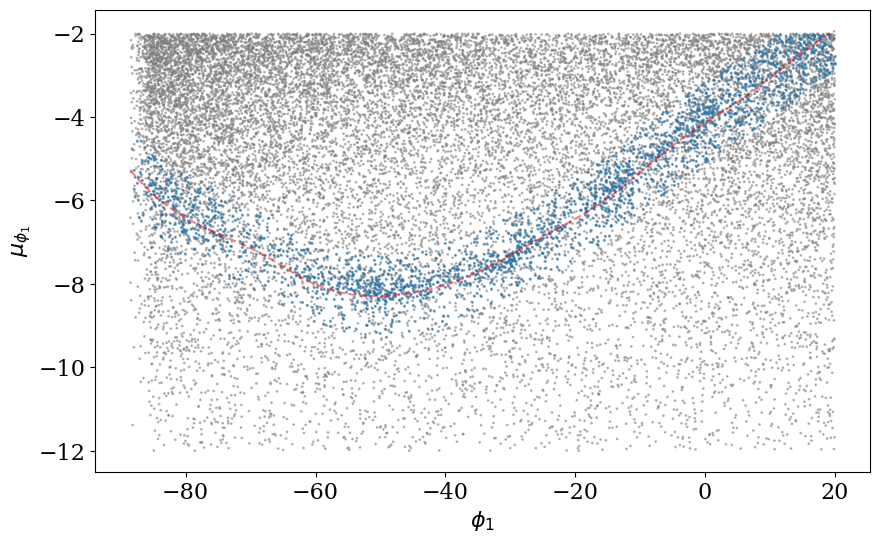

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['phi1'], get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['pm_phi1_cosphi2_corr'], ls='--',s=1, color='gray',alpha=0.5)
plt.plot(np.sort(get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['phi1']), PMPHI1(np.sort(get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['phi1']))-0.5,'--',c='red',alpha=0.5)
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut','pos_cut'])['phi1'], get_cuts(gaia_df, ['pm_cut_2','cmd_cut','pos_cut'])['pm_phi1_cosphi2_corr'],s=1,alpha=0.5)
#plt.plot(np.sort(gaia_plot.phi1), PMPHI1(np.sort(gaia_plot.phi1))-0.5-2,c='red')
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\mu_{\phi_{1}}$')

Text(0, 0.5, '$\\mu_{\\phi_{2}}$')

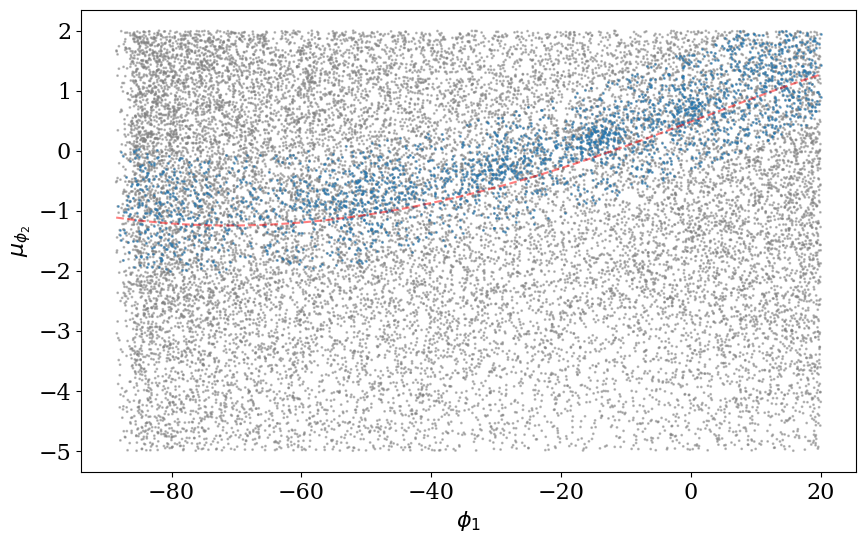

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['phi1'], get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['pm_phi2_corr'], ls='--',s=1, color='gray',alpha=0.5)
plt.plot(np.sort(get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['phi1']), PMPHI2(np.sort(get_cuts(gaia_df, ['pm_cut','cmd_cut','pos_cut'])['phi1']))-0.5,'--',c='red',alpha=0.5)
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut','pos_cut'])['phi1'], get_cuts(gaia_df, ['pm_cut_2','cmd_cut','pos_cut'])['pm_phi2_corr'],s=1,alpha=0.5)
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\mu_{\phi_{2}}$')

Text(0, 0.5, '$\\mu_{\\phi_{2}}$')

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


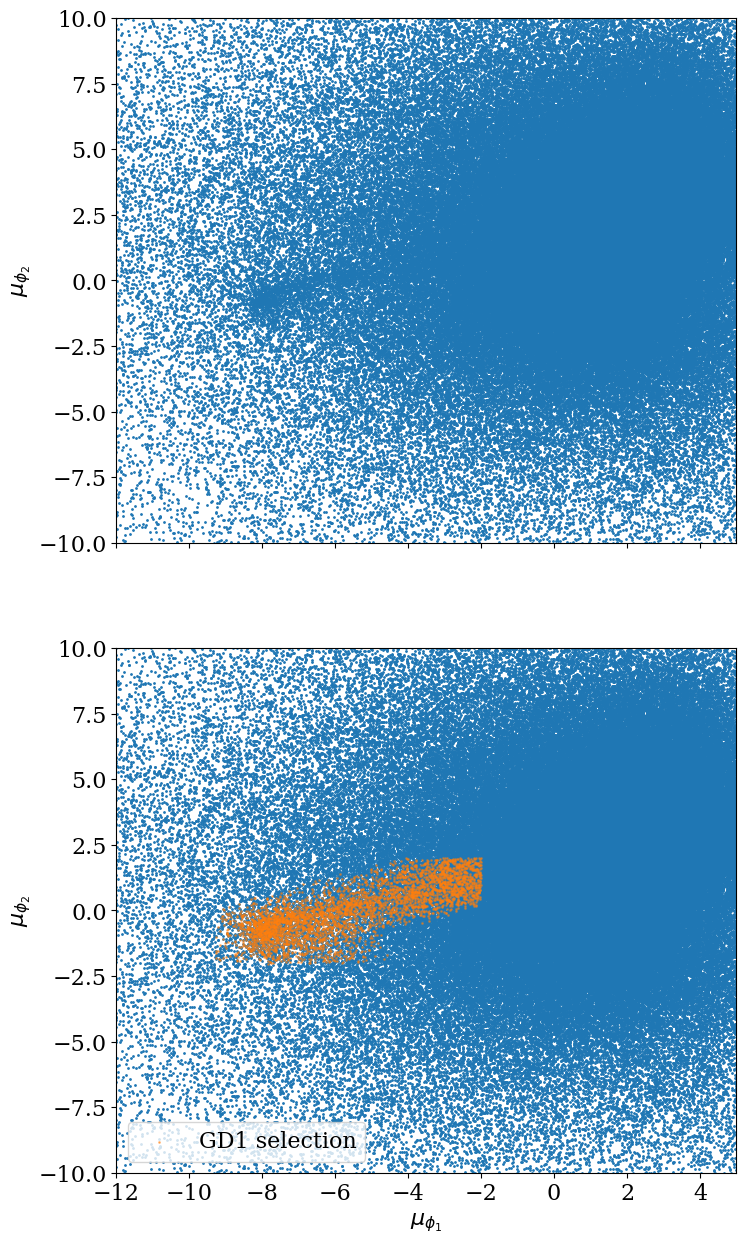

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True, figsize=(8,15))
ax1.scatter(get_cuts(gaia_df, ['cmd_cut','pos_cut'])['pm_phi1_cosphi2_corr'],get_cuts(gaia_df, ['cmd_cut','pos_cut'])['pm_phi2_corr'],s=1)
ax2.scatter(get_cuts(gaia_df, ['cmd_cut','pos_cut'])['pm_phi1_cosphi2_corr'],get_cuts(gaia_df, ['cmd_cut','pos_cut'])['pm_phi2_corr'],s=1)
ax2.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['pm_phi1_cosphi2_corr'],get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['pm_phi2_corr'],s=1,alpha=0.5,label='GD1 selection' )
ax2.legend()
ax1.set_xlim(-12,5)
ax1.set_ylim(-10,10)
ax2.set_xlim(-12,5)
ax2.set_ylim(-10,10)
ax2.set_xlabel('$\mu_{\phi_{1}}$')
ax2.set_ylabel('$\mu_{\phi_{2}}$')
ax1.set_ylabel('$\mu_{\phi_{2}}$')
#plt.savefig('mu1vmu2.png')

Text(0.5, 1.0, 'Gaia-ed3 in GD1 area with $\\mu$/CMD cuts')

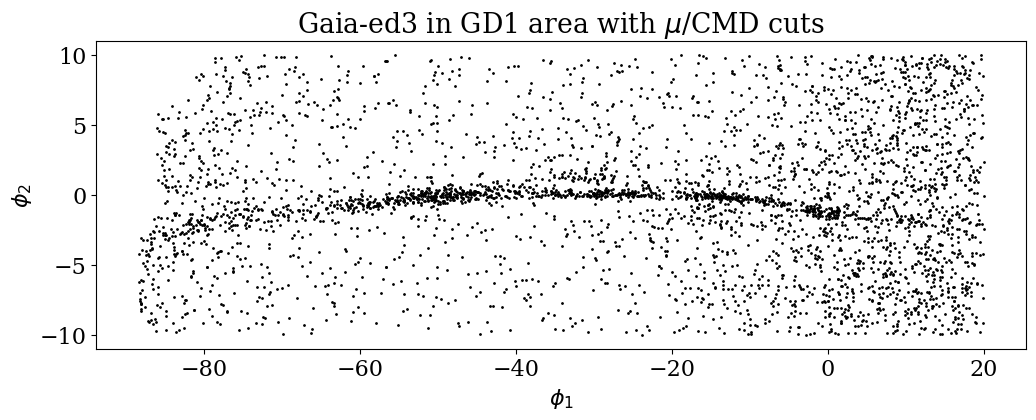

In [21]:
plt.figure(figsize=(12,4))
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi1'], 
            get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi2'], 
            s=1, color='k')
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\phi_{2}$')
plt.title('Gaia-ed3 in GD1 area with $\mu$/CMD cuts')

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Text(0.5, 1.0, 'Gaia-edr3 xmatched with DECals - GD1 stars')

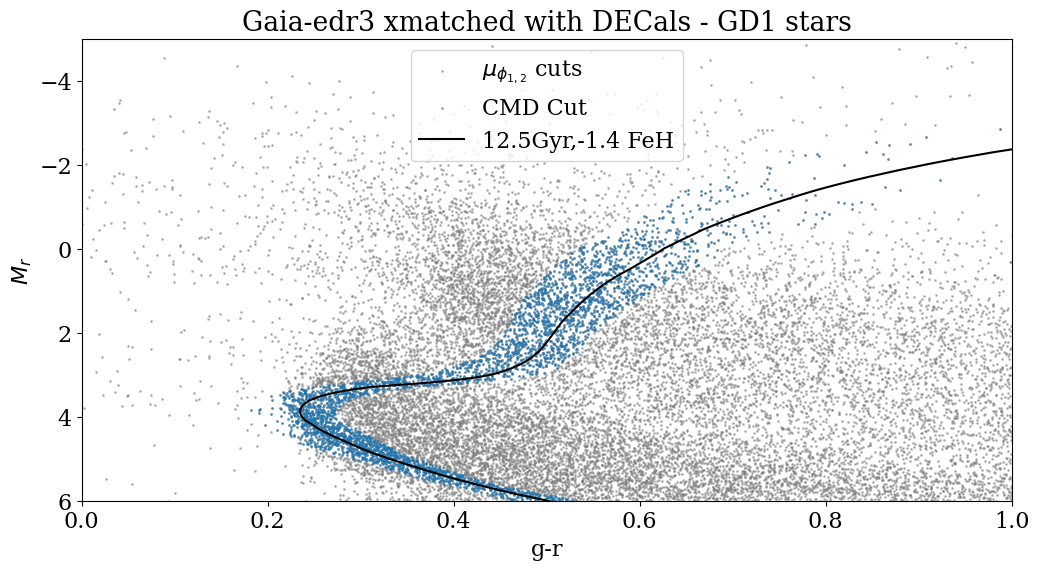

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(get_cuts(gaia_df, ['pm_cut_2'])['dered_mag_g'] - get_cuts(gaia_df, ['pm_cut_2'])['dered_mag_r'], 
            get_cuts(gaia_df, ['pm_cut_2'])['mag_r_dist_corr_1'],s=1,alpha=0.5, c='gray', label='$\mu_{\phi_{1,2}}$ cuts')
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['dered_mag_g'] - get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['dered_mag_r'], 
            get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['mag_r_dist_corr_1'],s=1,alpha=0.5, c='C0', label='CMD Cut')
plt.plot(iso12.g - iso12.r, iso12.r,c='k',ls='-',label='12.5Gyr,-1.4 FeH')
plt.xlim(0,1)
plt.gca().invert_yaxis()
plt.ylim(6,-5)
plt.legend()
plt.xlabel('g-r')
plt.ylabel('$M_{r}$')
plt.title('Gaia-edr3 xmatched with DECals - GD1 stars')

## Other Data

In [21]:
lamost_hdu = fits.open('lamost_gd1.fits')
sdss_hdu = fits.open('sdss_gd1.fits')
apogee_hdu = fits.open('apogee_gd1.fits')

In [22]:
lamost = Table(lamost_hdu[1].data)
sdss = Table(sdss_hdu[1].data)
apogee = Table(apogee_hdu[1].data)

In [23]:
desi_hdu = fits.open('desi_daily_gd1.fits')

In [24]:
desi = Table(desi_hdu[1].data)

In [23]:
def get_gd1_coords(df):
    dist = 8.5 #kpc
    df['mag_g'] = 22.5-2.5*np.log10(df['flux_g'])
    df['mag_r'] = 22.5-2.5*np.log10(df['flux_r'])

    coord_icrs = ICRS(ra=np.array(df['ra']) * u.deg,
        dec=np.array(df['dec']) * u.deg,
        radial_velocity=0 * u.km / u.s,
        distance=dist * u.kpc,
        pm_ra_cosdec=np.array(df['pmra']) * u.mas / u.year,
        pm_dec=np.array(df['pmdec']) * u.mas / u.year)

    coord_gd1 = coord_icrs.transform_to(gd1_frame)
    skycoord_gd1 = gc.reflex_correct(coord_gd1)
    df['phi1'] = coord_gd1.phi1
    df['phi2'] = coord_gd1.phi2
    df['pm_phi1_cosphi2'] = coord_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = coord_gd1.pm_phi2
    df['pm_phi1_cosphi2_corr'] = skycoord_gd1.pm_phi1_cosphi2
    df['pm_phi2_corr'] = skycoord_gd1.pm_phi2
    
    R_g = 3.214
    R_r = 2.165
    df['dered_mag_r'] = df['mag_r'] - R_r * df['ebv'] 
    df['dered_mag_g'] = df['mag_g'] - R_g * df['ebv'] 
    return df

In [26]:
lamost_df = get_gd1_coords(lamost)
sdss_df = get_gd1_coords(sdss)
apogee_df = get_gd1_coords(apogee)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [27]:
desi_df = get_gd1_coords(desi)
desi_df = dist_correction(desi_df)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [28]:
lamost_df = dist_correction(lamost_df)
sdss_df = dist_correction(sdss_df)
apogee_df = dist_correction(apogee_df)

In [24]:
def do_cuts(df):
    df = get_pos_cut(df)
    df = get_pm_cut_1(df)
    df = get_pm_cut_2(df)
    df = get_cmd_cut(df)
    return df

In [30]:
lamost_df = do_cuts(lamost_df)
sdss_df = do_cuts(sdss_df)
apogee_df = do_cuts(apogee_df)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


In [31]:
desi_df = do_cuts(desi_df)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Text(0, 0.5, '$\\phi_{2}$')

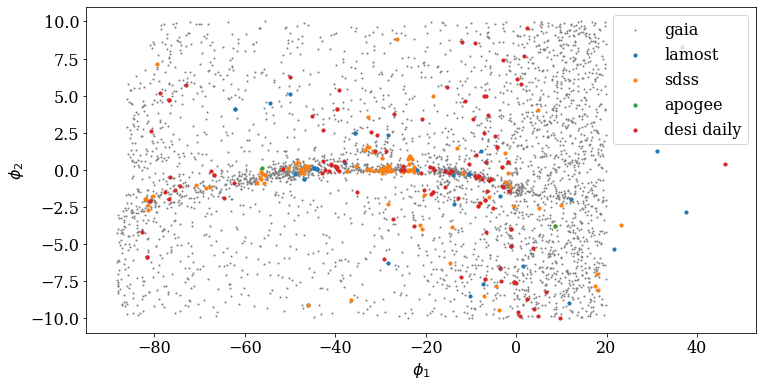

In [39]:
plt.figure(figsize=(12,6))
plt.scatter(gaia_df[gaia_df['pm_cut_2']&gaia_df['cmd_cut']]['phi1'], 
            gaia_df[gaia_df['pm_cut_2']&gaia_df['cmd_cut']]['phi2'], 
            s=1, color='gray',label='gaia')
plt.scatter(lamost_df[lamost_df['pm_cut_2']&lamost_df['cmd_cut']&lamost_df['feh_cut']]['phi1'], 
            lamost_df[lamost_df['pm_cut_2']&lamost_df['cmd_cut']&lamost_df['feh_cut']]['phi2'], 
            s=10, label='lamost')
plt.scatter(sdss_df[sdss_df['pm_cut_2']&sdss_df['cmd_cut']&sdss_df['feh_cut']]['phi1'], 
            sdss_df[sdss_df['pm_cut_2']&sdss_df['cmd_cut']&sdss_df['feh_cut']]['phi2'], 
            s=10, label='sdss')
plt.scatter(apogee_df[apogee_df['pm_cut_2']&apogee_df['cmd_cut']&apogee_df['feh_cut']]['phi1'], 
            apogee_df[apogee_df['pm_cut_2']&apogee_df['cmd_cut']&apogee_df['feh_cut']]['phi2'], 
            s=10, label='apogee')
plt.scatter(desi_df[desi_df['pm_cut_2']&desi_df['cmd_cut']&desi_df['feh_cut']]['phi1'], 
            desi_df[desi_df['pm_cut_2']&desi_df['cmd_cut']&desi_df['feh_cut']]['phi2'], 
            s=10, label='desi daily')
plt.legend()
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\phi_{2}$')
#plt.title('Gaia-ed3 in GD1 area with $\mu$/CMD cuts')

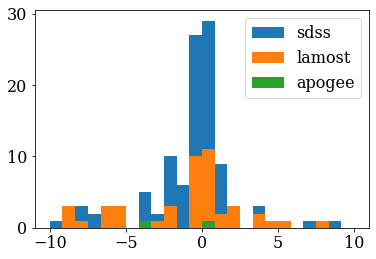

In [40]:
plt.hist(sdss_df[sdss_df['pm_cut_2']&sdss_df['cmd_cut']&sdss_df['feh_cut']]['phi2'], bins=np.linspace(-10,10,25),label='sdss')
plt.hist(lamost_df[lamost_df['pm_cut_2']&lamost_df['cmd_cut']&lamost_df['feh_cut']]['phi2'], bins=np.linspace(-10,10,25),label='lamost')
plt.hist(apogee_df[apogee_df['pm_cut_2']&apogee_df['cmd_cut']&apogee_df['feh_cut']]['phi2'], bins=np.linspace(-10,10,25), label='apogee')
plt.legend()

In [25]:
def feh_cut(df_,name):
    df_['feh_cut'] = False
    df_['feh_cut'][np.where((df_[name] < -1.5)&(df_[name] > -3.5))]  = True

    return df_

In [34]:
lamost_df = feh_cut(lamost_df, 'feh')

In [35]:
apogee_df = feh_cut(apogee_df, 'fe_h')

In [36]:
sdss_df = feh_cut(sdss_df, 'fehadop')

In [37]:
for n in desi_df.dtype.names:
    try:
        desi_df.rename_column(n, n.lower())
    except:
        pass

In [38]:
desi_df = feh_cut(desi_df, 'feh')

## Fuji Sample

In [26]:
fuji = pd.read_csv('rvtab-coadd-sv-fuji.csv')
fuji_sp = pd.read_csv('sptab-coadd-sv-fuji.csv')

In [27]:
fuji = fuji.sort_values('TARGET_RA').reset_index()
fuji_sp = fuji_sp.sort_values('TARGET_RA').reset_index()

In [28]:
fuji['FEH_SP'] = fuji_sp['FEH']

In [29]:
gd1_lim = [-30, 90, 120, 220]
fuji_gd1 = fuji[(fuji.TARGET_DEC>gd1_lim[0])&(fuji.TARGET_DEC<gd1_lim[1])&
                  (fuji.TARGET_RA>gd1_lim[2])&(fuji.TARGET_RA<gd1_lim[3])]

### Remove Repeats

In [30]:
fuji_gd1.sort_values('TARGET_RA',inplace=True)
dups = fuji_gd1[fuji_gd1.duplicated(subset=['TARGET_RA'],keep=False)]
len(fuji_gd1), len(np.unique(fuji_gd1.TARGET_RA)), len(dups), len(np.unique(dups.TARGET_RA))

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(359461, 305701, 104426, 50666)

In [31]:
better = []
for ra in np.unique(dups.TARGET_RA):
    d = dups[dups.TARGET_RA == ra]
    good = d[d.SN_R == max(d.SN_R)]
    better.append(good)

In [32]:
not_duplicated = fuji_gd1.drop_duplicates(subset=['TARGET_RA'],keep=False)
fuji_gd1 = pd.concat([not_duplicated, pd.concat(better)])

In [33]:
fuji_gd1.columns = fuji_gd1.columns.str.lower()

In [34]:
fuji_df = Table.from_pandas(fuji_gd1)

## Xmatch with Gaia Data

In [35]:
# matching by rounding these numbers. SHoudl be ok because needs to be within ~5 arcsec (?)
desi_round = fuji_gd1.round({'target_ra':2,'target_dec':2})
gaia_round = gaia_df.to_pandas().round({'ra':2,'dec':2})

In [36]:
gd1 = desi_round.merge(gaia_round, left_on=['target_ra','target_dec'], right_on=['ra','dec']) #,left_by='target_ra', right_by='ra', tolerance = 0.00138889,direction='nearest')

In [37]:
fuji_df = Table.from_pandas(gd1)

In [38]:
fuji_df = feh_cut(fuji_df, 'feh_sp')

In [39]:
fuji_df = do_cuts(fuji_df)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/matplotlib/path.py:582: UserWarning: Warning: converting a masked element to nan.
  result = _path.points_in_path(points, radius, self, transform)


In [59]:
len(fuji_gd1), len(gd1)

(305701, 76389)

In [60]:
plt.scatter(desi_gd1.ra, desi_gd1.dec, label='DESI daily')
plt.scatter(fuji_gd1.target_ra, fuji_gd1.target_dec, label='Fuji')
plt.scatter(gd1.target_ra, gd1.target_dec, label='Matched')
plt.xlabel('RA')
plt.ylabel("DEC")
plt.legend()

NameError: name 'desi_gd1' is not defined

(-100.0, 20.0)

/Users/pfagrelius/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


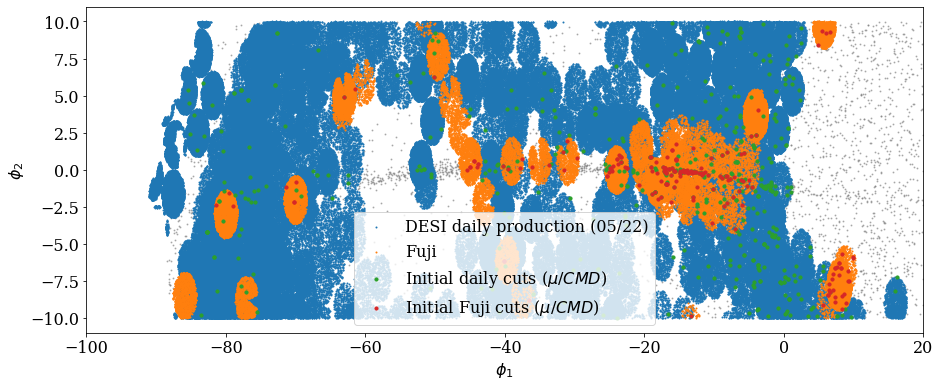

In [61]:
plt.figure(figsize=(15,6))

plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi1'], 
            get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi2'], 
            s=1, color='gray',alpha=0.5)
plt.scatter(desi_df['phi1'], desi_df['phi2'], s=1, label='DESI daily production (05/22)',color='C0')
plt.scatter(fuji_df['phi1'], fuji_df['phi2'], s=1, label='Fuji',color='C1')
plt.scatter(get_cuts(desi_df, ['pm_cut_2','cmd_cut'])['phi1'], 
            get_cuts(desi_df, ['pm_cut_2','cmd_cut'])['phi2'], 
            s=10, label='Initial daily cuts ($\mu/CMD$)',color='C2')#'{}'.format(len(desi_rec[desi_gd1.pm_cut_2&desi_gd1.cmd_cut&desi_gd1.pos_cut].phi1)))

plt.scatter(get_cuts(fuji_df, ['pm_cut_2','cmd_cut'])['phi1'], 
            get_cuts(fuji_df, ['pm_cut_2','cmd_cut'])['phi2'],  
            s=10, label='Initial Fuji cuts ($\mu/CMD$)',color='C3')#' {}'.format(len(gd1[gd1.pm_cut_2&gd1.cmd_cut&gd1.pos_cut])))
plt.legend()
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\phi_{2}$')
plt.xlim(-100, 20)

(-90.0, 20.0)

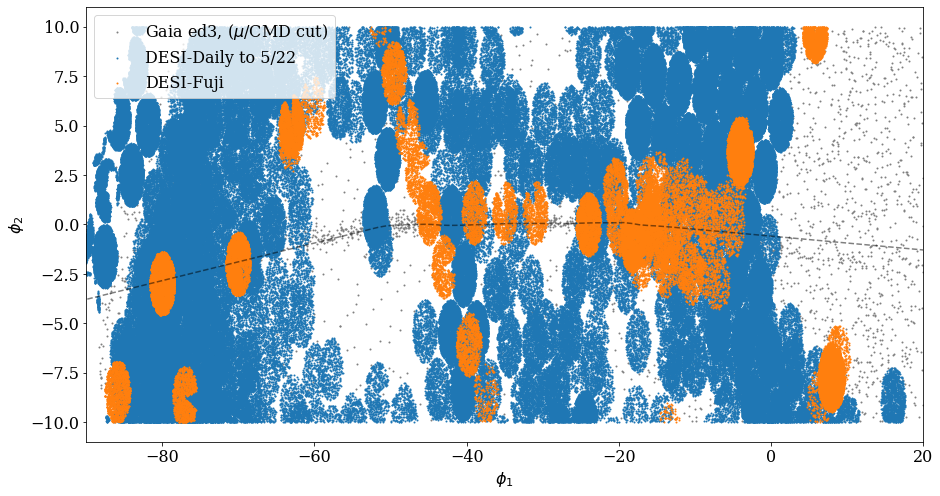

In [100]:
plt.figure(figsize=(15,8))
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi1'], get_cuts(gaia_df,['pm_cut_2','cmd_cut'])['phi2'],
            c='gray', s=1, label='Gaia ed3, ($\mu$/CMD cut)')
plt.scatter(desi_df['phi1'], desi_df['phi2'], s=1, label='DESI-Daily to 5/22')
plt.scatter(fuji_df['phi1'], fuji_df['phi2'], s=1, label='DESI-Fuji')
plt.legend(loc= 'upper left')
plt.plot(np.linspace(-100, 20, (20+100)), stream_(np.linspace(-100, 20, (20+100))), 
         c='k', alpha=0.5, ls = '--', label='GD1 Stream orbit')
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\phi_{2}$')
plt.xlim(-90,20)

## Spectroscopic Cuts

In [43]:
#From deBoer et al
stream_phi1 = [-53, -51, -49, -47, -45, -43, -41, -39, -37, -35, -33,-31,-29,-27,-25,-23,-21,-19,-17,-15,-13,-11]
stream_phi2 = [-.28,-.09,-.03,-.01,.01,-.05,-.05,-.02,0.0,.04,.05,.05,.04,.04,.06,.08,.08,.09,-.04,-.08,-.14,-.21]

stream_ = interpolate.interp1d(stream_phi1, stream_phi2, fill_value='extrapolate')

In [44]:
def stream_cut(df_):
    df_['stream'] = False
    df_['stream'][np.where(np.abs(df_['phi2'] - stream_(df_['phi1']))<0.5)] = True
    return df_

In [45]:
fuji_df = stream_cut(fuji_df)

Text(0.5, 1.0, 'Fuji Production')

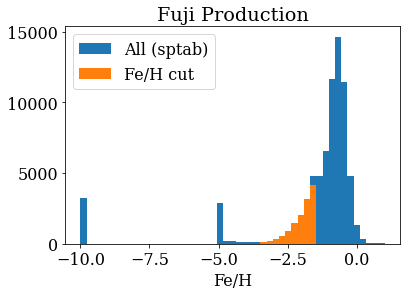

In [65]:
bins = np.linspace(min(gd1.feh_sp), max(gd1.feh_sp),50)
plt.hist(fuji_df['feh_sp'], bins=bins, label=('All (sptab)'))
plt.hist(get_cuts(fuji_df, ['feh_cut'])['feh_sp'], bins=bins, label='Fe/H cut')
plt.legend()
plt.xlabel('Fe/H')
plt.title('Fuji Production')

Text(0.5, 1.0, 'DESI Daily Production')

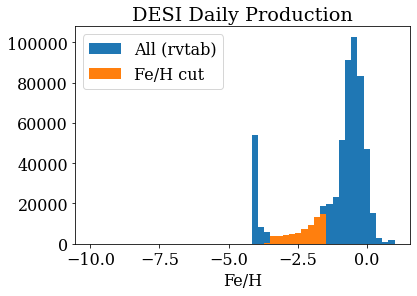

In [66]:
bins = np.linspace(min(gd1.feh_sp), max(gd1.feh_sp),50)
plt.hist(desi_df['feh'], bins=bins, label=('All (rvtab)'))
plt.hist(get_cuts(desi_df, ['feh_cut'])['feh'], bins=bins, label='Fe/H cut')
plt.legend()
plt.xlabel('Fe/H')
plt.title('DESI Daily Production')

In [46]:
# Make Vrad model with stars just along stream path
def get_new_func(df, param,poly=2):
    z = np.polyfit(df['phi1'], df[param], poly)
    p = np.poly1d(z)
    return p

In [47]:
gd1__ = fuji_df[fuji_df['pm_cut_2']&fuji_df['cmd_cut']&fuji_df['feh_cut']&fuji_df['stream']]

In [48]:
from scipy.interpolate import UnivariateSpline, CubicSpline
ix = np.argsort(gd1__['phi1'])
df_ = pd.DataFrame()
df_['phi1'] = np.array(gd1__['phi1'][ix])
df_['vrad'] = np.array(gd1__['vrad'][ix])
df_['vrad_err'] = np.array(gd1__['vrad_err'][ix])
df_ = df_.drop_duplicates(['phi1'])
spl = UnivariateSpline(np.array(df_.phi1), np.array(df_.vrad), w = np.array(df_.vrad_err), k=5, s=100)

In [49]:
vrad_mod = get_new_func(fuji_df[fuji_df['pm_cut_2']&fuji_df['cmd_cut']&fuji_df['feh_cut']&fuji_df['stream']], 'vrad', poly=2)

In [50]:
#From Sergey's code. Similar numbers in Koposov et al 2010 Table 1
RVX, RVY = (np.array([-47.49016522, -39.5436664, -31.43981117, -23.96538159, 
                      -17.27773407, -11.77025964, -5.71203777]),
            np.array([30.10772531, -21.56351641, -75.08015963, -119.36979539,
                    -161.81402966, -196.87665798, -246.70249821]))

RVI = scipy.interpolate.CubicSpline(RVX, RVY)

Text(0, 0.5, '$v_{rad}$')

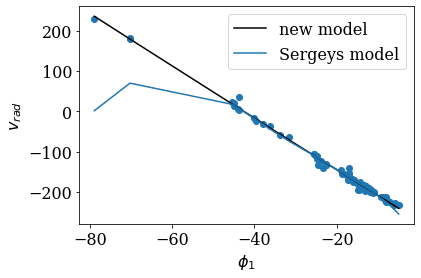

In [70]:
gd1__ = fuji_df[fuji_df['pm_cut_2']&fuji_df['cmd_cut']&fuji_df['feh_cut']&fuji_df['stream']]
plt.scatter(gd1__['phi1'], gd1__['vrad'])
plt.plot(np.sort(gd1__['phi1']), vrad_mod(np.sort(gd1__['phi1'])), c='k', label='new model')
plt.plot(np.sort(gd1__['phi1']), RVI(np.sort(gd1__['phi1'])), label='Sergeys model')
plt.legend()
plt.xlabel('$\phi_{1}$')
plt.ylabel('$v_{rad}$')

In [52]:
def get_vrad_cut(df_,name):
    df_['rv_cut'] = False
    delta_vrad = df_[name] - spl(df_['phi1']) 
    df_['rv_cut'][np.abs(delta_vrad)<50] = True
    df_['delta_vrad'] = delta_vrad
    return df_

In [53]:
fuji_df = get_vrad_cut(fuji_df,'vrad')

In [54]:
fuji_df.write('fuji_gd1_area.fits', format='fits')

In [192]:
fuji_all = fuji_df[fuji_df['rv_cut']&fuji_df['pm_cut_2']&fuji_df['cmd_cut']&fuji_df['feh_cut']&fuji_df['pos_cut']]
fuji_all_but_vrad = fuji_df[fuji_df['pm_cut_2']&fuji_df['cmd_cut']&fuji_df['feh_cut']&fuji_df['pos_cut']]

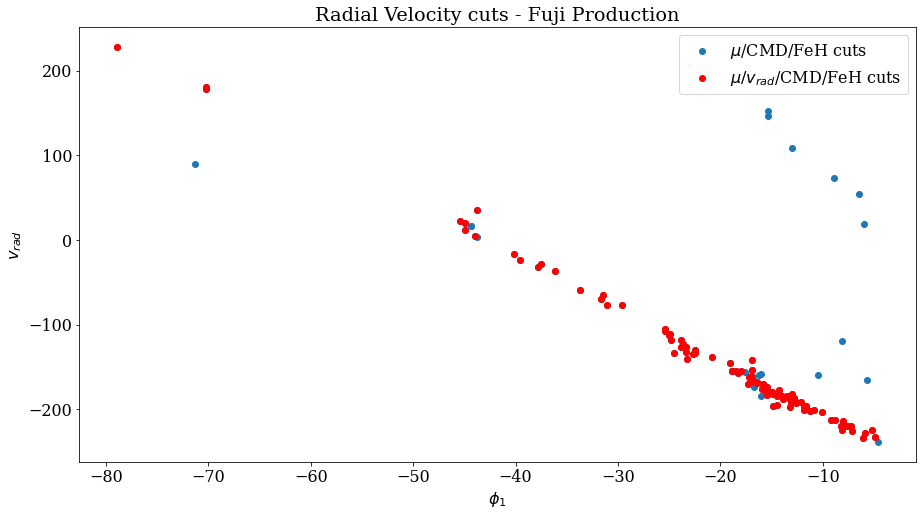

In [193]:
plt.figure(figsize=(15,8))
plt.scatter(fuji_all_but_vrad['phi1'], fuji_all_but_vrad['vrad'], label='$\mu$/CMD/FeH cuts')

#plt.plot(gd1[gd1.pm_cut_2&gd1.cmd_cut&gd1.feh_cut&gd1.stream].phi1, vrad_mod(gd1[gd1.pm_cut_2&gd1.cmd_cut&gd1.feh_cut&gd1.stream].phi1))
plt.scatter(fuji_all['phi1'], fuji_all['vrad'],c='red', label='$\mu/v_{rad}$/CMD/FeH cuts')
#plt.plot(np.sort(gd1.phi1), vrad_mod(np.sort(gd1.phi1))-30)
plt.xlabel('$\phi_{1}$')
plt.ylabel('$v_{rad}$')
plt.title('Radial Velocity cuts - Fuji Production')
plt.legend()

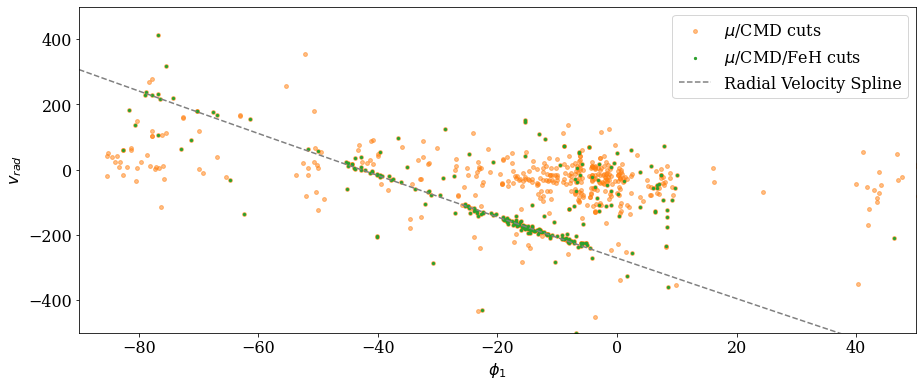

In [194]:
plt.figure(figsize=(15,6))
plt.scatter(get_cuts(fuji_df,['pm_cut_2','cmd_cut'])['phi1'], get_cuts(fuji_df,['pm_cut_2','cmd_cut'])['vrad'], 
            c='C1',s=15,alpha=0.5, label='$\mu$/CMD cuts')
plt.scatter(get_cuts(desi_df,['pm_cut_2','cmd_cut'])['phi1'], get_cuts(desi_df,['pm_cut_2','cmd_cut'])['vrad'], 
            c='C1',s=15, alpha=0.5)
plt.scatter(get_cuts(fuji_df,['pm_cut_2','cmd_cut','feh_cut'])['phi1'], get_cuts(fuji_df,['pm_cut_2','cmd_cut','feh_cut'])['vrad'], 
            c='C2',s=5, label='$\mu$/CMD/FeH cuts')
plt.scatter(get_cuts(desi_df,['pm_cut_2','cmd_cut','feh_cut'])['phi1'], get_cuts(desi_df,['pm_cut_2','cmd_cut','feh_cut'])['vrad'], 
            c='C2',s=5)
plt.plot(np.linspace(-100, 50, 150), vrad_mod(np.linspace(-100, 50, 150)), ls = '--',c='gray',label='Radial Velocity Spline')
plt.xlabel('$\phi_{1}$')
plt.ylabel('$v_{rad}$')
plt.ylim(-500,500)
plt.xlim(-90, 50)
#plt.title('Radial Velocity cuts - Fuji Production')
plt.legend()

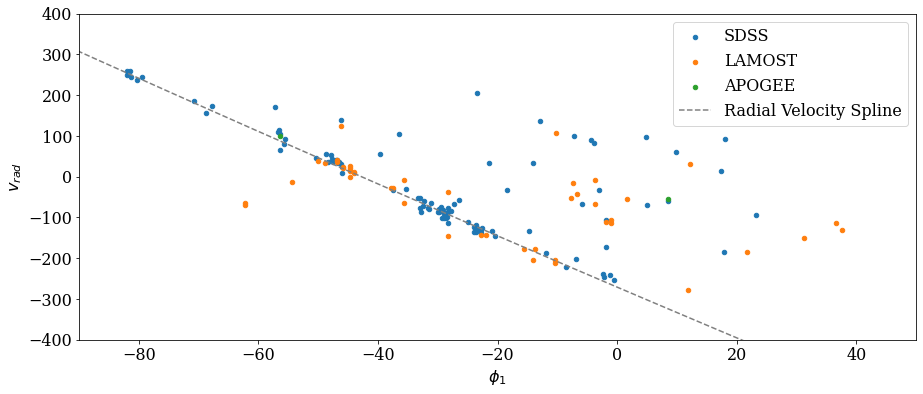

In [195]:
plt.figure(figsize=(15,6))
plt.scatter(get_cuts(sdss_df,['pm_cut_2','cmd_cut','feh_cut'])['phi1'], get_cuts(sdss_df,['pm_cut_2','cmd_cut','feh_cut'])['elodiervfinal'], 
            s=20, label='SDSS')
plt.scatter(get_cuts(lamost_df,['pm_cut_2','cmd_cut','feh_cut'])['phi1'], get_cuts(lamost_df,['pm_cut_2','cmd_cut','feh_cut'])['rv'], 
           s=20, label='LAMOST')
plt.scatter(get_cuts(apogee_df,['pm_cut_2','cmd_cut','feh_cut'])['phi1'], get_cuts(apogee_df,['pm_cut_2','cmd_cut','feh_cut'])['vhelio_avg'], 
           s=20,  label='APOGEE')

plt.plot(np.linspace(-100, 50, 150), vrad_mod(np.linspace(-100, 50, 150)), ls = '--',c='gray',label='Radial Velocity Spline')
plt.xlabel('$\phi_{1}$')
plt.ylabel('$v_{rad}$')
plt.ylim(-400,400)
plt.xlim(-90, 50)
#plt.title('Radial Velocity cuts - Fuji Production')
plt.legend()

In [196]:
lamost_df = get_vrad_cut(lamost_df,'rv')
sdss_df = get_vrad_cut(sdss_df,'elodiervfinal')
apogee_df = get_vrad_cut(apogee_df,'vhelio_avg')

In [197]:
desi_df = get_vrad_cut(desi_df,'vrad')

In [198]:
all_cuts = ['rv_cut','pm_cut_2','cmd_cut','feh_cut','pos_cut']
all_but_rv = ['pm_cut_2','cmd_cut','feh_cut','pos_cut']

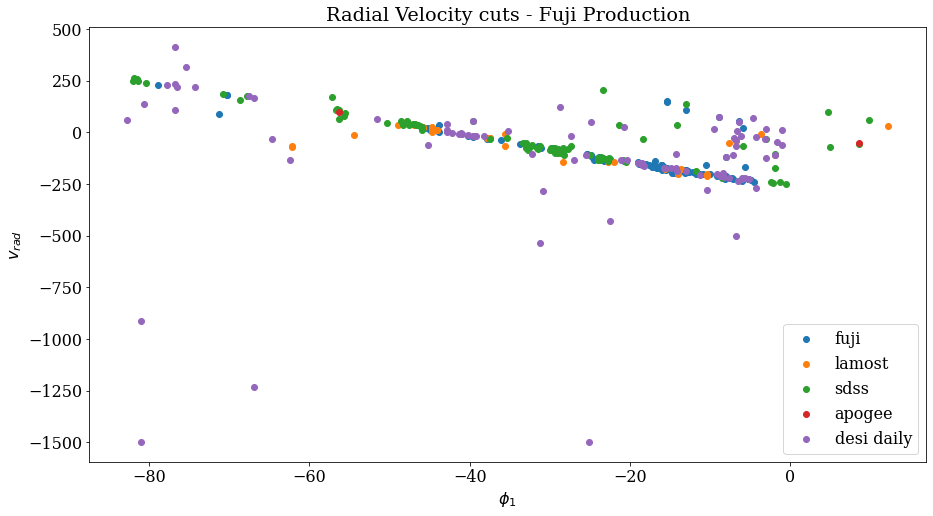

In [199]:
plt.figure(figsize=(15,8))
plt.scatter(get_cuts(fuji_df, all_but_rv)['phi1'], get_cuts(fuji_df, all_but_rv)['vrad'], label='fuji')
plt.scatter(get_cuts(lamost_df, all_but_rv)['phi1'], get_cuts(lamost_df, all_but_rv)['rv'], label='lamost')
plt.scatter(get_cuts(sdss_df, all_but_rv)['phi1'], get_cuts(sdss_df, all_but_rv)['elodiervfinal'], label='sdss')
plt.scatter(get_cuts(apogee_df, all_but_rv)['phi1'], get_cuts(apogee_df, all_but_rv)['vhelio_avg'], label='apogee')
plt.scatter(get_cuts(desi_df, all_but_rv)['phi1'], get_cuts(desi_df, all_but_rv)['vrad'], label='desi daily')


plt.xlabel('$\phi_{1}$')
plt.ylabel('$v_{rad}$')
plt.title('Radial Velocity cuts - Fuji Production')
plt.legend()

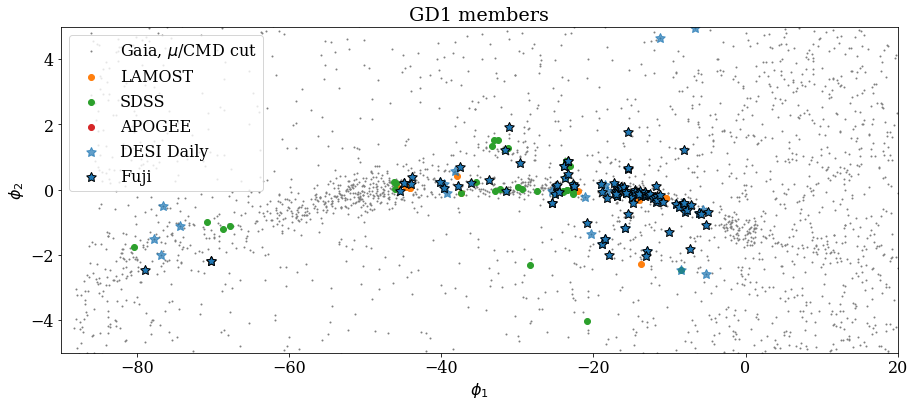

In [200]:
plt.figure(figsize=(15,6))
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi1'], get_cuts(gaia_df,['pm_cut_2','cmd_cut'])['phi2'],c='gray', s=1, label='Gaia, $\mu$/CMD cut')

plt.scatter(get_cuts(lamost_df, all_cuts)['phi1'], get_cuts(lamost_df, all_cuts)['phi2'], c='C1',label='LAMOST')
plt.scatter(get_cuts(sdss_df, all_cuts)['phi1'], get_cuts(sdss_df, all_cuts)['phi2'], c='C2',label='SDSS')
plt.scatter(get_cuts(apogee_df, all_cuts)['phi1'], get_cuts(apogee_df, all_cuts)['phi2'], c='C3',label='APOGEE')
plt.scatter(get_cuts(desi_df, all_cuts)['phi1'], get_cuts(desi_df, all_cuts)['phi2'], marker=(5,1), c='C0', s=100, alpha=0.7,label='DESI Daily')
plt.scatter(get_cuts(fuji_df, all_cuts)['phi1'], get_cuts(fuji_df, all_cuts)['phi2'],marker=(5,1), c='C0', s=100, edgecolor='k',label='Fuji')
plt.ylim(-5,5)
plt.xlim(-90,20)
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\phi_{2}$')
plt.title('GD1 members')
plt.legend()

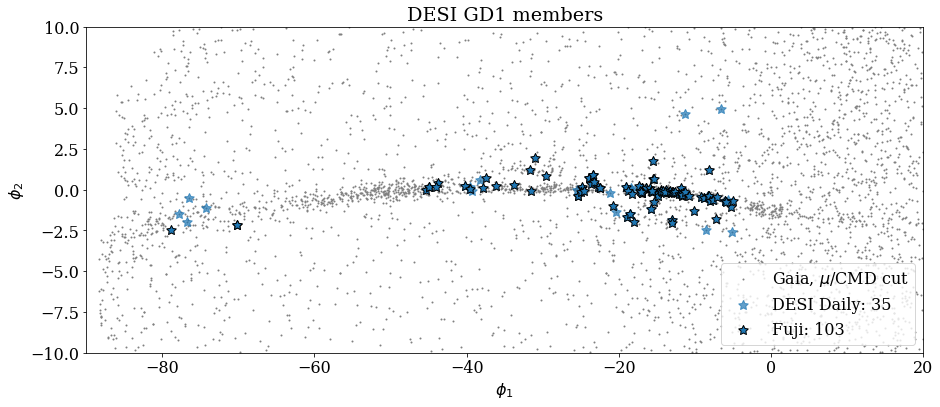

In [201]:
plt.figure(figsize=(15,6))
plt.scatter(get_cuts(gaia_df, ['pm_cut_2','cmd_cut'])['phi1'], get_cuts(gaia_df,['pm_cut_2','cmd_cut'])['phi2'],c='gray', s=1, label='Gaia, $\mu$/CMD cut')

plt.scatter(get_cuts(desi_df, all_cuts)['phi1'], get_cuts(desi_df, all_cuts)['phi2'], marker=(5,1), c='C0', s=100, alpha=0.7,label='DESI Daily: {}'.format(len(get_cuts(desi_df, all_cuts))))
plt.scatter(get_cuts(fuji_df, all_cuts)['phi1'], get_cuts(fuji_df, all_cuts)['phi2'],marker=(5,1), c='C0', s=100, edgecolor='k',label='Fuji: {}'.format(len(get_cuts(fuji_df, all_cuts))))
plt.xlim(-90,20)
plt.ylim(-10,10)
plt.xlabel('$\phi_{1}$')
plt.ylabel('$\phi_{2}$')
plt.title('DESI GD1 members')
plt.legend(loc='lower right')